In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual

@interact(x=True, y=1.0)
def g(x, y):
    return (x, y)

In [1]:
%matplotlib inline
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy import misc
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC 


def _calculate_hog(img, orient, pix_per_cell, cell_per_block, 
                   vis=False, feature_vec=True):
    return hog(img, orientations=orient,
                pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block),
                transform_sqrt=True,
                visualise=vis, feature_vector=feature_vec)


def get_hog_features(img, channel=0, **kwargs):
    if channel == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            features = _calculate_hog(img[:,:,channel], vis=False, feature_vec=True, **kwargs)
            hog_features.append(features)
        hog_features = np.ravel(hog_features)
    else:
        hog_features = _calculate_hog(img[:,:,channel], vis=False, feature_vec=True, **kwargs)

    return hog_features


def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel()


# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

_spaces = {
    'hsv': cv2.COLOR_RGB2HSV,
    'luv': cv2.COLOR_RGB2LUV,
    'hls': cv2.COLOR_RGB2HLS,
    'yuv': cv2.COLOR_RGB2YUV,
    'ycrcb': cv2.COLOR_RGB2YCrCb,
}

# Define a function to extract features from a list of images
def extract_features(
        imgs, 
        color_space='RGB',
        spatial_size=(32, 32),
        hist_bins=32,
        orient=9,
        pix_per_cell=8,
        cell_per_block=2,
        hog_channel=0,
        spatial_feat=True,
        hist_feat=True, 
        hog_feat=True):
    features = []
    for img in imgs:
        file_features = []

        # allow for passing in a filename pointing to an image or an 
        # actual image as ndarray
        if hasattr(img, 'upper'):
            img = misc.imread(img)

        cv2_cspace = _spaces.get(color_space.lower())
        feature_image = cv2.cvtColor(img, cv2_cspace) if cv2_cspace else np.copy(img)

        if spatial_feat:
            file_features.append(bin_spatial(feature_image, size=spatial_size))

        if hist_feat:
            file_features.append(color_hist(feature_image, nbins=hist_bins))

        if hog_feat:
            kwargs = {
                    'orient': orient,
                    'pix_per_cell': pix_per_cell,
                    'cell_per_block': cell_per_block,
            }
            file_features.append(get_hog_features(feature_image, hog_channel, **kwargs))

        features.append(np.concatenate(file_features))

    return features


def single_img_features(img, *args, **kwargs):
    return extract_features([img], *args, **kwargs)[0]

In [2]:
def slide_window(img,
                 x_start_stop=[None, None],
                 y_start_stop=[None, None],
                 xy_window=(64, 64),
                 xy_overlap=(0.5, 0.5)
                ):
    x_window_size, y_window_size = xy_window

    x_step, y_step = map(int, np.array(xy_window) * np.array(xy_overlap))

    max_x = img.shape[1] - x_window_size + 1
    max_y = img.shape[0] - y_window_size + 1
    
    if not all(x_start_stop):
        x_start_stop = [0, max_y]
    if not all(y_start_stop):
        y_start_stop = [0, max_y]
        
    # sanity check boundaries
    if x_start_stop[0] < 0:
        x_start_stop[0] = 0
    if y_start_stop[0] < 0:
        y_start_stop[0] = 0

    x_start_stop[1] = min(x_start_stop[1], max_x)
    y_start_stop[1] = min(y_start_stop[1], max_y)
        
    x_ranges = map(int, x_start_stop + [x_step])
    y_ranges = map(int, y_start_stop + [y_step])

    x_steps = range(*x_ranges)
    y_steps = range(*y_ranges)

    window_list = []
    for y in y_steps:
        for x in x_steps:
            window_list.append((
                (x, y),
                (x + x_window_size, y + y_window_size)
            ))

    return window_list

def get_color():
    return [np.random.randint(0, 255) for i in range(3)]
    

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)

    if callable(color):
        get_colors_fn = color
    else:
        get_colors_fn = lambda: color

    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], get_colors_fn(), thick)
    return imcopy

(-0.5, 1279.5, 719.5, -0.5)

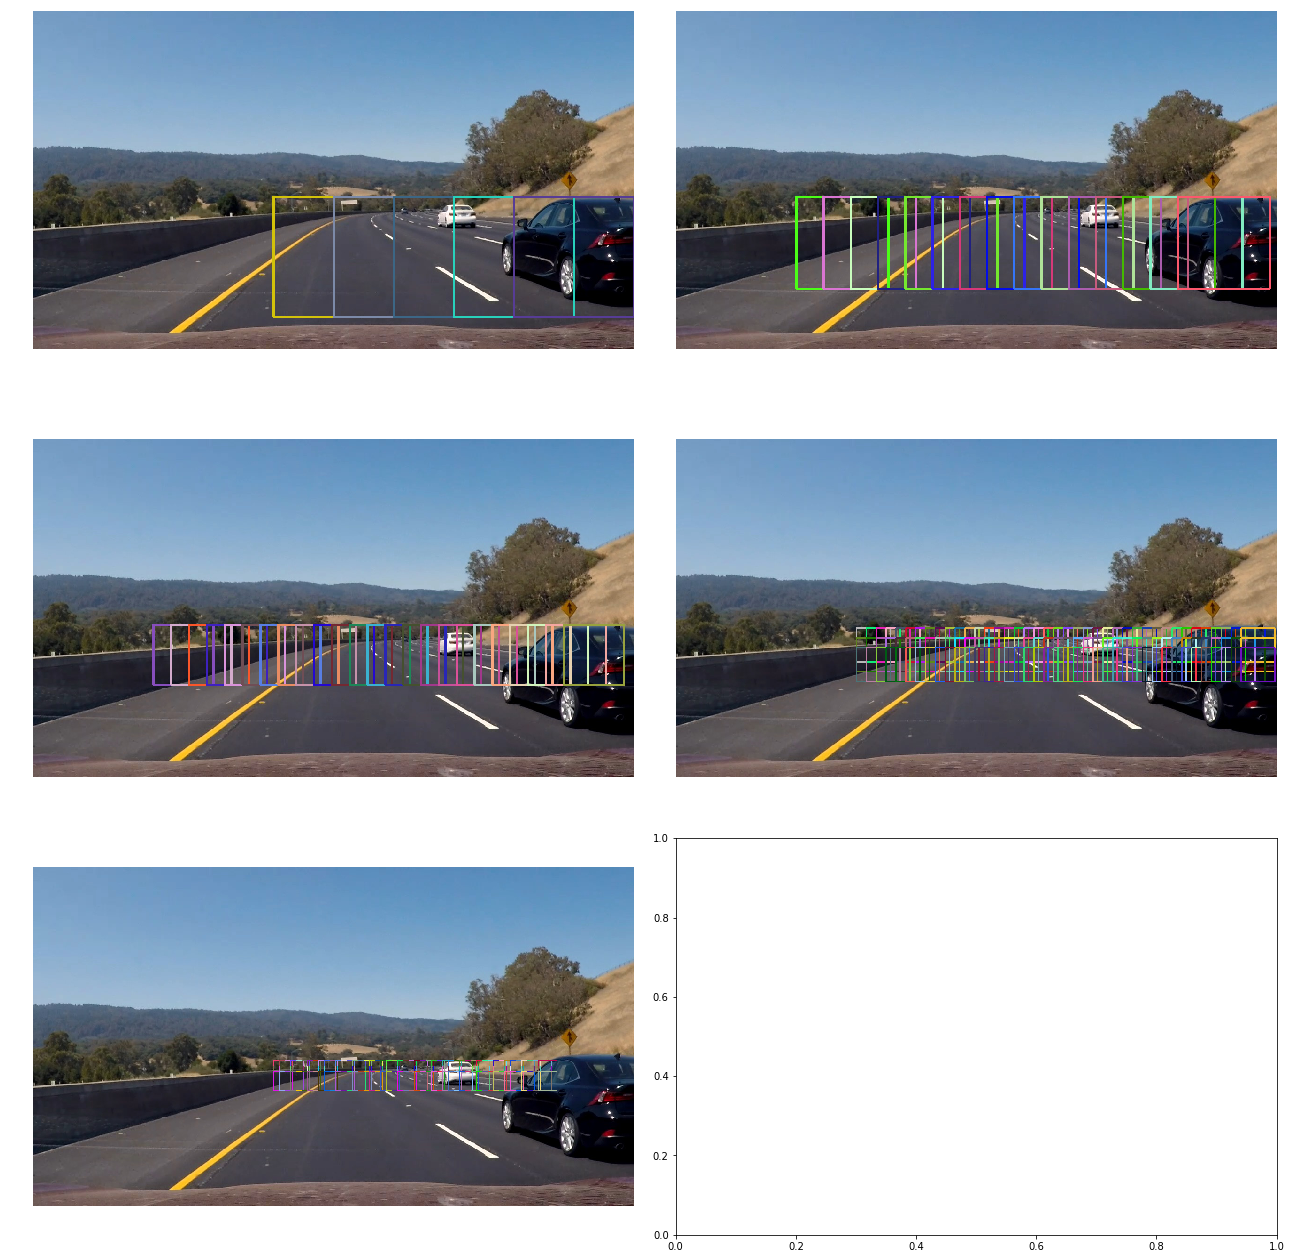

In [3]:
img = misc.imread('test_images/test12.jpg')

height, width = img.shape[:2]

really_close = {
    'x_start_stop': [width * .4, width],
    'y_start_stop': [height * 0.55, height * 0.6],
    'xy_window': (256, 256),
}
close = {
    'x_start_stop': [width * .2, width],
    'y_start_stop': [height * 0.55, height * 0.6],
    'xy_window': (196, 196),
    'xy_overlap': (0.3, 0.3),
}
medium = {
    'x_start_stop': [width * .2, width],
    'y_start_stop': [height * 0.55, height * 0.6],
    'xy_window': (128, 128),
    'xy_overlap': (0.3, 0.3),
}
far = {
    'x_start_stop': [width * .3, width],
    'y_start_stop': [height * 0.56, height * 0.62],
    'xy_window': (72, 72),
    'xy_overlap': (0.3, 0.3),
}
really_far = {
    'x_start_stop': [width * .4, width * 0.8],
    'y_start_stop': [height * 0.58, height * 0.60],
    'xy_window': (16, 16),
    'xy_overlap': (0.4, 0.4),
}
really_far = {
    'x_start_stop': [width * .4, width * 0.85],
    'y_start_stop': [height * 0.57, height * 0.62],
    'xy_window': (40, 40),
    'xy_overlap': (0.3, 0.3),
}


fig, (row1, row2, row3) = plt.subplots(3, 2, figsize=(18, 18))
fig.tight_layout()

(ax1, ax2) = row1
(ax3, ax4) = row2
(ax5, ax6) = row3

windows = slide_window(img, **really_close)
ax1.imshow(draw_boxes(img, windows, color=get_color, thick=3))
ax1.axis('off')

windows = slide_window(img, **close)
ax2.imshow(draw_boxes(img, windows, color=get_color, thick=3))
ax2.axis('off')

windows = slide_window(img, **medium)
ax3.imshow(draw_boxes(img, windows, color=get_color, thick=3))
ax3.axis('off')

windows = slide_window(img, **far)
ax4.imshow(draw_boxes(img, windows, color=get_color, thick=2))
ax4.axis('off')

windows = slide_window(img, **really_far)
ax5.imshow(draw_boxes(img, windows, color=get_color, thick=1))
ax5.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

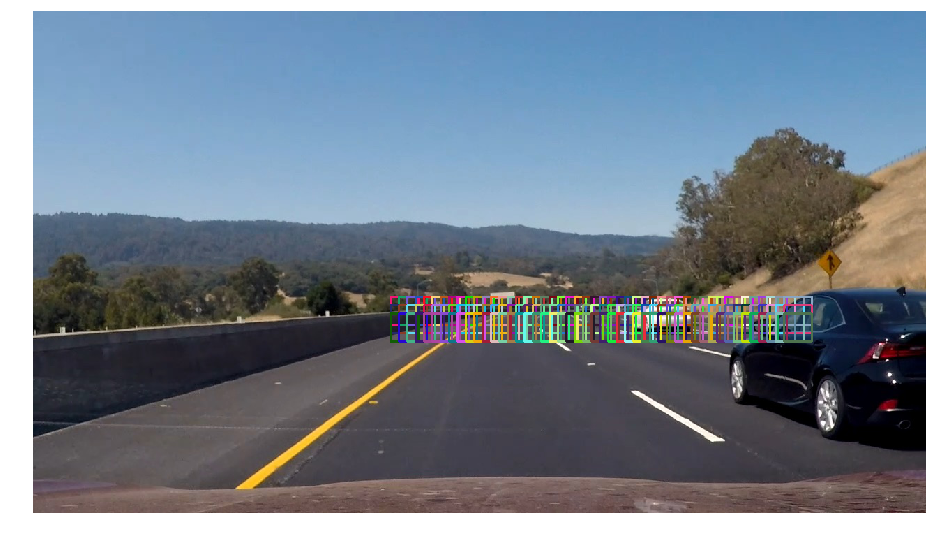

In [4]:
windows = slide_window(img, **really_far)

plt.figure(figsize=(16, 12))
plt.imshow(draw_boxes(img, windows, color=get_color, thick=2))
plt.axis('off')

In [5]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
    on_windows = []

    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, 
                                       color_space=color_space,
                                       spatial_size=spatial_size,
                                       hist_bins=hist_bins,
                                       orient=orient, 
                                       pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat,
                                       hist_feat=hist_feat,
                                       hog_feat=hog_feat)

        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))

        #6) Predict using your classifier
        prediction = clf.predict(test_features)

        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    return on_windows

In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
# Increase the number of bins for the color distribution features
hist_bins = 32
spatial_feat = True
hist_feat = False
hog_feat = True

In [7]:
img = misc.imread('vehicles/GTI_Left/image0912.png')
img = misc.imread('vehicles/KITTI_extracted/98.png')

print(img.max(), img.min())
#colorspace = 'YCrCb'
#orient = 32
#pix_per_cell = 16

#bins_range = (0, 256)
#channel1_hist = np.histogram(img[:,:,0], bins=hist_bins, range=bins_range)
#plt.plot(channel1_hist[0])
#plt.show()


255 2


-0.687502701479 3.57844272078


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


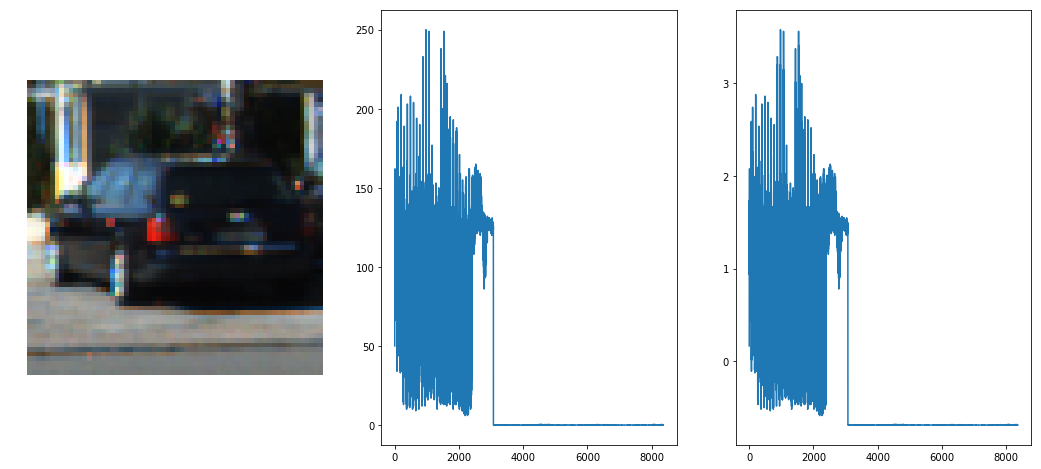

In [8]:
features = single_img_features(
        img, 
        color_space=color_space,
        spatial_size=spatial_size,                        
        hist_bins=hist_bins,
        orient=orient,
        pix_per_cell=pix_per_cell,
        cell_per_block=cell_per_block,
        hog_channel=hog_channel, 
        spatial_feat=spatial_feat,
        hist_feat=hist_feat, 
        hog_feat=hog_feat)

from sklearn.preprocessing import RobustScaler, MinMaxScaler

# Scale features
X_scaler = StandardScaler().fit(features)
scaled_features = X_scaler.transform(features)

print(scaled_features.min(), scaled_features.max())
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

ax1.imshow(img)
ax1.axis('off')
ax2.plot(features)
ax3.plot(scaled_features)

In [9]:
def train():
    cars = list(glob.glob('vehicles/*/*'))
    notcars = list(glob.glob('non-vehicles/*/*'))

    kwargs = {
        'color_space': color_space,                                                                                                                                   
        'spatial_size': spatial_size,  
        'hist_bins': hist_bins,
        'orient': orient,  
        'pix_per_cell': pix_per_cell,
        'cell_per_block': cell_per_block,
        'hog_channel': hog_channel,  
        'spatial_feat': spatial_feat,
        'hist_feat': hist_feat,  
        'hog_feat': hog_feat,
    }
    
    car_features = extract_features(cars, **kwargs)
    notcar_features = extract_features(notcars, **kwargs)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    print(X.shape)
    # Fit a per-column scaler
    X_scaler = MinMaxScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:', orient, 'orientations', pix_per_cell,
        'pixels per cell and', cell_per_block, 'cells per block')
    print('Feature vector length:', len(X_train[0]))

    t = time.time()

    svc = LinearSVC()
    svc.fit(X_train, y_train)

    print(round(time.time() - t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

    return svc, X_scaler

In [ ]:
svc, X_scaler = train()

(17760, 8364)


In [ ]:
import pickle

with open('svc-nohist.p', 'wb') as fh:
    fh.write(pickle.dumps({
        'svc': svc,
        'scaler': X_scaler,
        'notes': """
            color_space = 'YCrCb'
            orient = 9
            pix_per_cell = 8
            cell_per_block = 2
            hog_channel = 'ALL'
            spatial_size = (32, 32)
            hist_bins = 32
            spatial_feat = True
            hist_feat = False
            hog_feat = True
        """
    }))

In [ ]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

In [ ]:
def draw_labeled_bboxes(img, labels, n_cars):
    for car_number in range(1, n_cars + 1):
        # Find pixels with each car_number label value
        nonzero = (labels == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)

    return img

In [ ]:
with open("svc.p", "rb") as fh:
    data = pickle.load(fh)
    svc = data['svc']
    X_scaler = data['scaler']

from scipy.ndimage.measurements import label

test_images = list(glob.glob('test_images/*.jpg'))
n_test_images = len(test_images) + len(test_images) % 2

# do 2 columns
fig, rows = plt.subplots(n_test_images, 2, figsize=(12, 60))
fig.tight_layout()

row = 0
col = 0
for fn in test_images:
    #if col >= 2:
    #    col = 0
    #    row += 1
        
    #ax = rows[row][col]
    
    ax = rows[row][0]
    
    img = misc.imread(fn)
    height, width = img.shape[:2]
    
    windowing = (really_close, close, medium, far, really_far)

    draw_image = np.copy(img)

    windows = []
    for window_kwargs in windowing:
        windows.extend(slide_window(img, **window_kwargs))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)
    
    #plt.figure(figsize=(16, 12))
    ax.imshow(window_img)
    ax.axis('off')
    
    #col += 1
    
    ax = rows[row][1]
    
    #print(img.shape)
    heatmap = np.zeros(img.shape[:2])
    add_heat(heatmap, hot_windows)
    heatmap[heatmap <= 2] = 0
    labels, n_cars = label(heatmap)
 
    final_img = draw_labeled_bboxes(np.copy(img), labels, n_cars)
    
    ax.imshow(final_img, cmap="gray")
    ax.axis('off')
    
    row += 1


In [ ]:
def process_clip(img):
    height, width = img.shape[:2]
    windowing = (really_close, close, medium, far, really_far)

    draw_image = np.copy(img)

    windows = []
    for window_kwargs in windowing:
        windows.extend(slide_window(img, **window_kwargs))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)
    
    heatmap = np.zeros(img.shape[:2])
    add_heat(heatmap, hot_windows)
    heatmap[heatmap <= 2] = 0
    labels, n_cars = label(heatmap)
 
    return draw_labeled_bboxes(np.copy(img), labels, n_cars)

In [ ]:
import os
import urllib.request
from moviepy.editor import VideoFileClip

input_fn = 'project_video.mp4'
if not os.path.isfile(input_fn):
    print('Fetching input video from S3...')
    urllib.request.urlretrieve('http://brianz-udacity-sdc.s3.amazonaws.com/p4/project_video.mp4', input_fn)
    
output_fn = 'output.mp4'
video_clip = VideoFileClip(input_fn)
processor = video_clip.fl_image(process_clip)
processor.write_videofile(output_fn, audio=False)